In [ ]:
! pip install --upgrade rasterio
! pip install -U git+https://github.com/qubvel/segmentation_models.pytorch


  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-ow6p1259
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-ow6p1259
     |████████████████████████████████| 58 kB 795 kB/s eta 0:00:01
     |████████████████████████████████| 376 kB 1.7 MB/s eta 0:00:01
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88664 sha256=0ff360d4b0f3ee6d47f90fb724a210841ced0fa0a5e091f610d004d7c260cdf5
  Stored in directory: /tmp/pip-ephem-wheel-cache-7nu5ho1r/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=aedd5cad3b64ab02b9146e51fd3ad49aecc399f471276583bd11222dbde6f6c6
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrai

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # image plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300 #increase plot resolution

#Raster data handling
from PIL import Image
import skimage
from skimage import io, transform
import rasterio as rio # geo-oriented plotting library
from rasterio import features
import cv2

#PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, Sampler # custom dataset handling
import torch.autograd.profiler as profiler # to track model inference and detect leaks
from torchvision import transforms, utils
from torch.autograd import Variable
from torch import nn
from torch.nn.modules.padding import ReplicationPad2d
import torchvision.models as models
from torch import optim
from collections import OrderedDict
import segmentation_models_pytorch as smp #semantic segmentation models and utils
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

#Augmentations
import albumentations as alb
from albumentations.pytorch import ToTensorV2

#Logging errors and progress, sending them to tg-bot
import requests
import traceback

#Other
from pathlib import Path # to have path strings as PosixPath objexts
import pathlib
from pyproj import CRS
import geopandas as gpd # to make dataframes out of geojson files
import itertools
import re
from tqdm.notebook import tqdm
tqdm.pandas()
import os
import gc
from timeit import default_timer as time
import copy
import json
import logging
import datetime




In [ ]:
from descartes import PolygonPatch

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
gc.collect()

81

In [ ]:
root_folder = '../input/spacenet-7-change-detection-chips-and-masks/chip_dataset/chip_dataset/change_detection/'
csv_path = '../input/spacenet-7-change-detection-chips-and-masks/annotations.csv'

BATCH_SIZE = 64
NUM_WORKERS = 8

In [ ]:
df = pd.read_csv(csv_path)
df.sample(5)

,chip_path,mask_path,target,fname,im_dates,year1,month1,year2,month2,x,y,im_name,is_blank
1207614,L15-1014E-1375N_4056_2688_13/chips/2018_5_2019...,L15-1014E-1375N_4056_2688_13/masks/2018_5_2019...,1,global_monthly_2018_5_2019_12_chip_x640_y640_L...,2018_5_2019_12,2018,5,2019,12,640,640,L15-1014E-1375N_4056_2688_13,NaN
1835506,L15-0924E-1108N_3699_3757_13/chips/2019_5_2018...,L15-0924E-1108N_3699_3757_13/masks/2019_5_2018...,1,global_monthly_2019_5_2018_5_chip_x64_y64_L15-...,2019_5_2018_5,2019,5,2018,5,64,64,L15-0924E-1108N_3699_3757_13,NaN
209373,L15-1204E-1202N_4816_3380_13/chips/2018_4_2018...,L15-1204E-1202N_4816_3380_13/masks/2018_4_2018...,0,global_monthly_2018_4_2018_9_chip_x768_y960_L1...,2018_4_2018_9,2018,4,2018,9,768,960,L15-1204E-1202N_4816_3380_13,blank
1204476,L15-1014E-1375N_4056_2688_13/chips/2018_1_2018...,L15-1014E-1375N_4056_2688_13/masks/2018_1_2018...,0,global_monthly_2018_1_2018_8_chip_x960_y576_L1...,2018_1_2018_8,2018,1,2018,8,960,576,L15-1014E-1375N_4056_2688_13,blank
1303122,L15-1709E-1112N_6838_3742_13/chips/2018_6_2019...,L15-1709E-1112N_6838_3742_13/masks/2018_6_2019...,0,global_monthly_2018_6_2019_10_chip_x128_y64_L1...,2018_6_2019_10,2018,6,2019,10,128,64,L15-1709E-1112N_6838_3742_13,blank


In [ ]:
df.target.mean()

0.17641241530490234

In [ ]:
df[df.target == 0].is_blank.value_counts()

blank    2644968
Name: is_blank, dtype: int64

In [ ]:
aoi = df['im_name'].unique()
len(aoi)

60

In [ ]:
train_aoi = aoi[:40]
test_aoi = aoi[-20:-10]
valid_aoi = aoi[-10:]

In [ ]:
def choose_aoi(df, names):
    mask = df['im_name'].map(lambda x: x in names)
    return df[mask].reset_index(drop=True)

df_dict = {'train' : choose_aoi(df, train_aoi),
          'test' : choose_aoi(df, test_aoi),
          'valid' : choose_aoi(df, valid_aoi)
          }

del(df)

In [ ]:
class TorchDataset(Dataset):
    """Dataset class
    Args:
        root_folder: Path object, root directory of picture dataset
        csv: pandas.DataFrame, untidy df with all data relationships
        aug: albumentations dictionary
        preproc: callable, preprocessing function related to specific encoder
        grayscale: boolean, preprocessing condition to grayscale colored rasters
    Return:
        image, mask tensors"""

    def __init__(self, root_folder, df, aug = None, preproc = None, grayscale = True):
        self.root_folder = root_folder
        self.csv = df
        self.aug = aug
        self.preproc = preproc
        self.grayscale = grayscale

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        chip_path = self.root_folder + self.csv.loc[idx,'chip_path']
        # read chip into numpy array
        chip = skimage.io.imread(root_folder + self.csv.loc[idx,'chip_path']).astype('float32')
        if self.grayscale:
            gray1 = np.dot(chip[:,:,0:3], [0.2989, 0.5870, 0.1140])
            gray2 = np.dot(chip[:,:,3:], [0.2989, 0.5870, 0.1140])
            chip = np.divide(np.stack((gray1, gray2),axis = 2),255).astype('float32')
        # get target for corresponding chip
        mask = np.abs(np.divide(skimage.io.imread(root_folder + self.csv.loc[idx,'mask_path']),255)).astype('float32')
        # apply augmentations
        if self.aug:
            sample = self.aug(image=chip, mask=mask)
            image, mask = sample['image'], sample['mask']
            mask = mask.unsqueeze(0)
            if self.grayscale:
                sample = {'I1':image[0,:,:].unsqueeze(0),'I2':image[1,:,:].unsqueeze(0), 'label':mask}
            else:
                sample = {'I1':image[0:3,:,:],'I2':image[3:,:,:], 'label':mask}
            del(image,mask,chip,gray1,gray2)
            return sample
        else:
            image = torch.Tensor(np.moveaxis(chip, 2, 0))
            mask = torch.Tensor(mask).unsqueeze(0)
            if self.grayscale:
                sample = {'I1':image[0,:,:].unsqueeze(0),'I2':image[1,:,:].unsqueeze(0), 'label':mask}
            else:
                sample = {'I1':image[0:3,:,:],'I2':image[3:,:,:], 'label':mask}
            del(mask,chip,gray1,gray2)
            return sample






class BalancedSampler(Sampler):
    """Balancer for torch.DataLoader to adjust chips loading"""

    def __init__(self, dataset, percentage = 0.5):
        """
        dataset: custom torch dataset
        percentage: float number between 0 and 1, percentage of change containing pictures in batch
        """
        assert 0 <= percentage <= 1,'percentage must be a value between 0 and 1'

        self.dataset = dataset
        self.pct = percentage
        self.len_ = len(dataset)

    def __len__(self):
        return self.len_

    def __iter__(self):
        # get indices for chips containing change and blank ones
        change_chip_idxs = np.where(self.dataset.csv['target'] == 1)[0]
        blank_chip_idxs = np.where(self.dataset.csv['target'] == 0)[0]
        # randomly sample from the incides of each class according to percentage value
        change_chip_idxs = np.random.choice(change_chip_idxs,int(self.len_ * self.pct), replace=True)
        blank_chip_idxs = np.random.choice(blank_chip_idxs,int(self.len_ * (1 - self.pct))+1, replace=False)
        # stack and shuffle of sampled indices
        all_idxs = np.hstack([change_chip_idxs,blank_chip_idxs])
        np.random.shuffle(all_idxs)
        return iter(all_idxs)

In [ ]:
chip_dimension = 64
augs = {
    'train': alb.Compose([
        alb.PadIfNeeded(min_height=chip_dimension,min_width=chip_dimension,value=0,p=1),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        ToTensorV2() #apparently doesn't work properly with smp Unet, included in get_preprocessing function
    ]),
    'test': alb.Compose([
        alb.PadIfNeeded(min_height=chip_dimension,min_width=chip_dimension,value=0,p=1),
        ToTensorV2()
    ]),
    'valid': alb.Compose([
        alb.PadIfNeeded(min_height=chip_dimension,min_width=chip_dimension,value=0,p=1),
        ToTensorV2()
    ]),
}

In [ ]:
augs['train']

Compose([
  PadIfNeeded(always_apply=False, p=1, min_height=64, min_width=64, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=0, mask_value=None),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [ ]:
from sklearn.metrics import confusion_matrix

class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    """Fast enough iou calculation function"""
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    #outputs = outputs.detach()
    #labels = labels.detach()

    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded.mean() # to get a batch average

def segmentation_report(running_preds, running_labels):
    """Function to get a closer look to a confusion metrics and related metrics"""
    rp = running_preds.flatten()
    rl = running_labels.flatten()
    tn, fp, fn, tp = confusion_matrix(rl, rp, labels=[0,1]).ravel()
    px_accuracy = (tp+tn) / (tp+fp+tn+fn)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    #calculating intersection over union
    intersection = np.logical_and(rl, rp)
    union = np.logical_or(rl, rp)
    iou_score = np.sum(intersection) / np.sum(union)
    fmeasure = 2 * precision * recall / (precision + recall)
    #making report
    report = { 'tp/tn/fp/fn' : (tp,tn,fp,fn),
              'px_accuracy': px_accuracy,
              'precision': precision,
              'recall': recall,
              'iou_score': iou_score,
              'fmeasure':fmeasure
             }
    return report


def log_batch_statistics(batch_number,batch_labels,batch_preds,phase,loss,since,num_batches,period=500):
    if batch_number % period == 0:
        iou_score = segmentation_report(batch_preds,batch_labels)
        time_elapsed = time.time() - since

        if phase == 'train':
            telegram_bot_sendtext('TRAINING BATCH')
        else:
            telegram_bot_sendtext('VALIDATION BATCH')

        telegram_bot_sendtext('-'*50)
        telegram_bot_sendtext(f'\n{batch_number}/{num_batches-1}:')
        telegram_bot_sendtext(f'Total Time Elapsed: {time_elapsed/60:.2f} mins')
        telegram_bot_sendtext(f'Batch Loss: {loss.item():.4f}\n')
        telegram_bot_sendtext(f"``` IoU_score:{iou_score}\n ```")
        telegram_bot_sendtext('-'*50)

def break_time_limit(start_time,time_limit=28080):
    time_elapsed = time()-start_time
    if time_elapsed > time_limit:
        sys.exit()

In [ ]:
#learning policy params
grayscale = True
if grayscale == True:
    in_channels = 2
else: in_channels = 6

N_EPOCHS = 25

# turning on GPU if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# cleaning GPU
gc.collect()
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True

# mean percentage of positives is 6.5% from the frame, median is 3.4%, so weights for bce loss are required.
weights = torch.Tensor([28]).to(device)

#criterion = torch.nn.BCEWithLogitsLoss(pos_weight = weights)
criterion = IoULoss()


Using device: cuda:0



Change detection FC model

In [ ]:
import torch.nn.functional as F

class Unet(nn.Module):
    """EF segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(Unet, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)


        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.Sigmoid()

    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x))))
        x12 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43, kernel_size=2, stride=2)


        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43.size(3) - x4d.size(3), 0, x43.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33.size(3) - x3d.size(3), 0, x33.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22.size(3) - x2d.size(3), 0, x22.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12.size(3) - x1d.size(3), 0, x12.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)

class SiamUnet_diff(nn.Module):
    """SiamUnet_diff segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_diff, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.Sigmoid()

    def forward(self, x1, x2):


        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)

        ####################################################
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)



        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), torch.abs(x43_1 - x43_2)), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), torch.abs(x33_1 - x33_2)), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), torch.abs(x22_1 - x22_2)), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), torch.abs(x12_1 - x12_2)), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)


In [ ]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

In [ ]:
if grayscale == True:
    #net, net_name = smp.Unet('resnet34', in_channels = 2, activation='sigmoid'), 'FC-EF'
    net, net_name = SiamUnet_diff(1,1), 'FC-Siam-diff'
    #net, net_name = SiamUnet_conc(1,1), 'FC-Siam-conc'
    #net, net_name = Unet(2,1), 'FC-EF'

else:
    #net, net_name = smp.Unet('resnet34', in_channels = 6, activation='sigmoid'), 'FC-EF'
    net, net_name = SiamUnet_diff(3, 1), 'FC-Siam-diff'
    #net, net_name = SiamUnet_conc(3,1), 'FC-Siam-conc'
    #net, net_name = Unet(3*2,1), 'FC-EF'
net = net.to(device)

In [ ]:
net

SiamUnet_diff(
  (conv11): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do11): Dropout2d(p=0.2, inplace=False)
  (conv12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do12): Dropout2d(p=0.2, inplace=False)
  (conv21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do21): Dropout2d(p=0.2, inplace=False)
  (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do22): Dropout2d(p=0.2, inplace=False)
  (conv31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
#defining datasets, samplers and dataloaders
datasets = {x:TorchDataset(root_folder = root_folder,df = df_dict[x],aug = None, preproc = None, grayscale = grayscale) for x in ['train','test','valid']}

samplers = {'train':BalancedSampler(datasets['train'], percentage = 1),
            'test':BalancedSampler(datasets['test'], percentage = 1),
            'valid':BalancedSampler(datasets['valid'], percentage = 1),
            'sanity':BalancedSampler(datasets['train'], percentage = 1)}

dataloaders = {x: DataLoader(dataset=datasets[x],
                             batch_size=BATCH_SIZE,
                             sampler=samplers[x],
                             num_workers=16) for x in ['train','test','valid']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'test', 'valid']}



In [ ]:
def train(net, n_epochs = 25):
    print('epoch,train_loss,train_iou,test_loss,test_iou',file=open('loss_log.txt', 'a'))
    start_time = time()
    # telegram_bot_sendtext(f'Training started')
    scaler = GradScaler()

    iou = -1
    best_iou = -1

    lss = 100000000
    best_lss = 100000000

    train_epoch_iou = 0
    test_epoch_iou = 0


    #defining optimizer and scheduler
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.005)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)


    for epoch_index in tqdm(range(n_epochs)):
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(n_epochs))
        train_running_loss = 0.0
        train_running_iou = 0.0
        test_running_loss = 0.0
        test_running_iou = 0.0

        for phase in ['train','test']:
            if phase == 'train':
                net.train()  # Set model to training mode
            else:
                net.eval()   # Set model to evaluate mode

            num_batches = len(dataloaders[phase])
            for batch_index, batch in enumerate(tqdm(dataloaders[phase])):
                torch.cuda.empty_cache()
                I1 = Variable(batch['I1'].float().to(device))
                I2 = Variable(batch['I2'].float().to(device))
                labels = Variable(batch['label'].float().to(device))

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = net(I1, I2)
                        #outputs = net(torch.stack((I1, I2), axis = 1).squeeze()) # fusion for smp.Unet
                        loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs.data, 1)
                    del(_,outputs)
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        optimizer.step()
                        scaler.update()
                    del(I1, I2)
#                     except Exception as e:
#                             msg = log_traceback(e)
#                             telegram_bot_sendtext(f'failed at batch {batch_index}, with message: {msg}')
#                             raise e
#                             break
#                     log_batch_statistics(batch_index,labels.data.long(),outputs.data.long(),phase,loss=loss,num_batches=num_batches,since=start_time)
                if phase == 'train':
                    train_running_loss += loss.item()
                    # train_running_iou += iou_pytorch(preds.int().to('cpu'), labels.int().to('cpu')).item()
                else:
                    test_running_loss += loss.item()
                    # test_running_iou += iou_pytorch(preds.int().to('cpu'), labels.int().to('cpu')).item()

            if phase == 'train':
                scheduler.step()
                train_epoch_loss = train_running_loss / dataset_sizes[phase] * BATCH_SIZE
                # train_epoch_iou = train_running_iou / dataset_sizes[phase] * BATCH_SIZE
            else:
                test_epoch_loss = test_running_loss / dataset_sizes[phase] * BATCH_SIZE
                # test_epoch_iou = test_running_iou / dataset_sizes[phase] * BATCH_SIZE
            #print(f'{epoch_index},{train_epoch_loss}, {train_epoch_iou},{test_epoch_loss},{test_epoch_iou}', file=open('loss_log.txt', 'a'))
#             print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=20), file=open("profiler.txt", "a"))
#             telegram_send_file('./profiler.txt')
            '''
            if epoch_iou > best_iou:
                best_iou = epoch_iou
                save_str = f'./net{net_name}-best_epoch-' + str(epoch_index + 1) + '_iou_score-' + str(best_iou) + '.pth.tar'
                torch.save(net, save_str)
#                 telegram_send_file(save_str)
                print('Model saved!')
            '''
            if (phase  == 'train') and (train_epoch_loss < best_lss):
                best_lss = train_epoch_loss
                save_str = f'./net{net_name}-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(best_lss) + '.pth.tar'
                torch.save(net, save_str)
                #telegram_send_file(save_str)
                print('Model saved!')

            if (phase == 'test') and (test_epoch_loss < best_lss):
                best_lss = test_epoch_loss
                save_str = f'./net{net_name}-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(best_lss) + '.pth.tar'
                torch.save(net, save_str)
                #telegram_send_file(save_str)
                print('Model saved!')


    model_str = './model.pth.tar'
    torch.save(net, model_str)
    #telegram_send_file(model_str)
    print('Model saved!')
    time_elapsed = time() - start_time
    print()
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val change_accuracy: {best_fm:4f}')

    return net


In [1]:
#model = train(net,2)

In [ ]:
dataset_sizes['train']

2240512

In [ ]:
dataset_sizes['valid']

525312

Visualization

In [ ]:
model_path = '../input/model-fc-diff/model.pth.tar'
model = torch.load(model_path)

In [ ]:
model = model.cuda()

In [ ]:
model.eval()

SiamUnet_diff(
  (conv11): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do11): Dropout2d(p=0.2, inplace=False)
  (conv12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do12): Dropout2d(p=0.2, inplace=False)
  (conv21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do21): Dropout2d(p=0.2, inplace=False)
  (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do22): Dropout2d(p=0.2, inplace=False)
  (conv31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
def val_model(model):
    iou_list = []
    for batch_index, batch in enumerate(tqdm(dataloaders['valid'])):
        I1 = Variable(batch['I1'].float().to(device))
        I2 = Variable(batch['I2'].float().to(device))
        labels = Variable(batch['label'].int().to(device))
        outputs = model(I1,I2)
        iou_list.append(iou_pytorch(outputs.int().to('cpu'), labels.to('cpu')))
    print(np.mean(iou_list))

In [ ]:
val_model(model)

  0%|          | 0/8208 [00:00<?, ?it/s]

0.8350038


In [ ]:
batch = next(iter(dataloaders['valid']))
n = np.random.randint(BATCH_SIZE)
_, preds = torch.max(model(batch['I1'].cuda(),batch['I2'].cuda()).data,1)

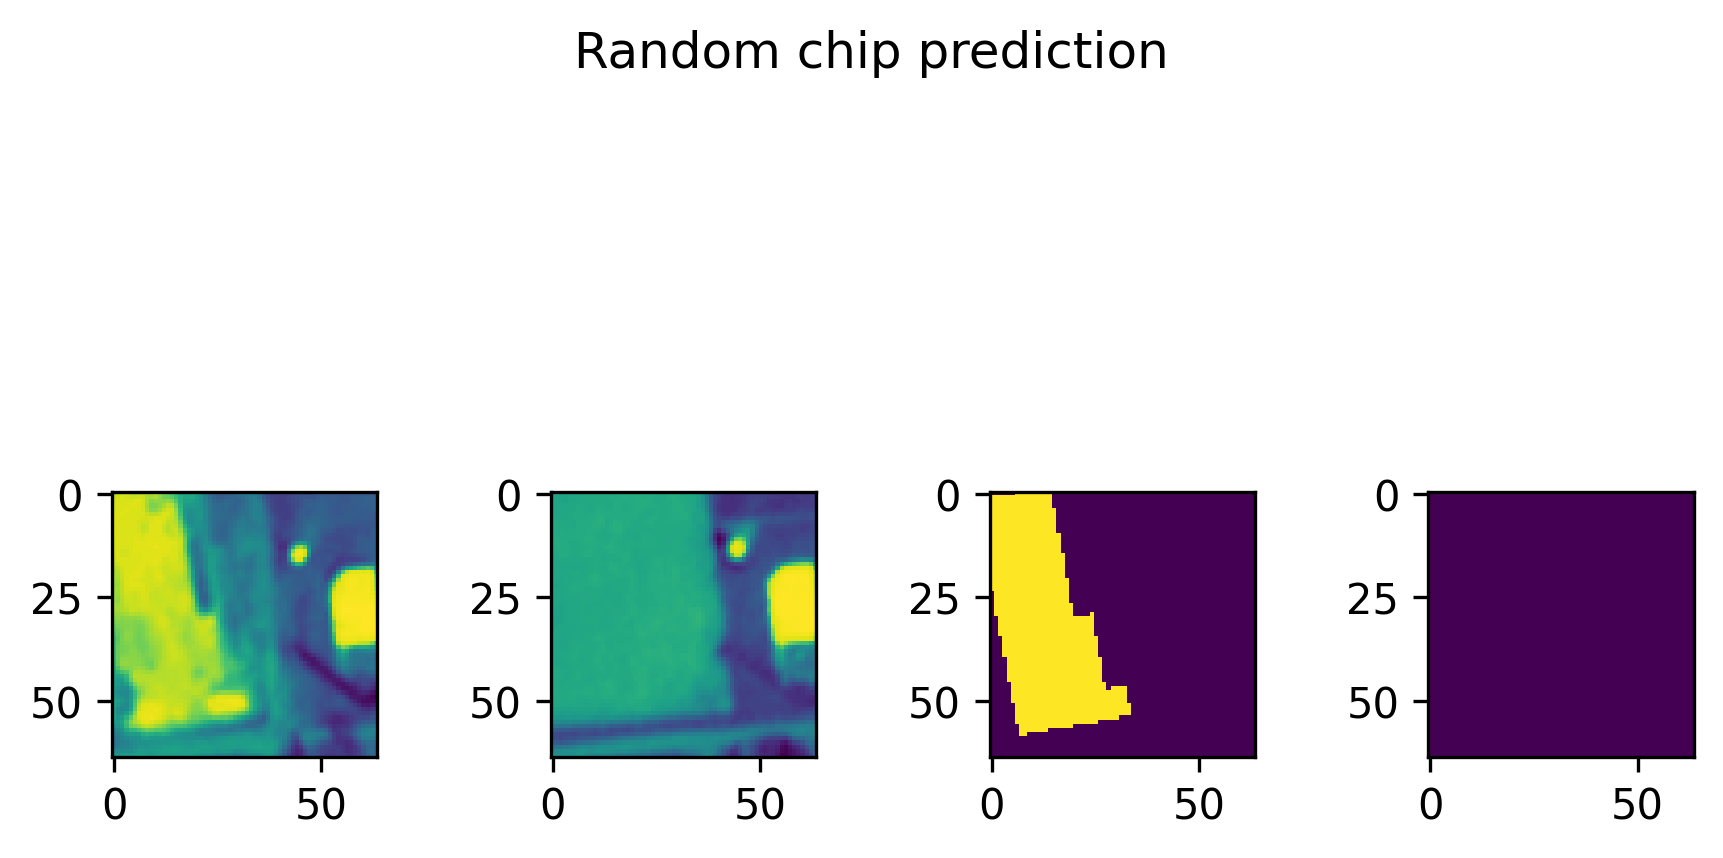

In [ ]:
fig, axs = plt.subplots(1,4)
fig.suptitle('Random chip prediction')
fig.tight_layout()
axs[0].imshow(batch['I1'][n].squeeze())
axs[1].imshow(batch['I2'][n].squeeze())
axs[2].imshow(batch['label'][n].squeeze())
axs[3].imshow(preds[n].cpu())

In [ ]:
#torch.stack((datasets['train'][0]['I1'],datasets['train'][0]['I1']),axis = 1).squeeze().shape

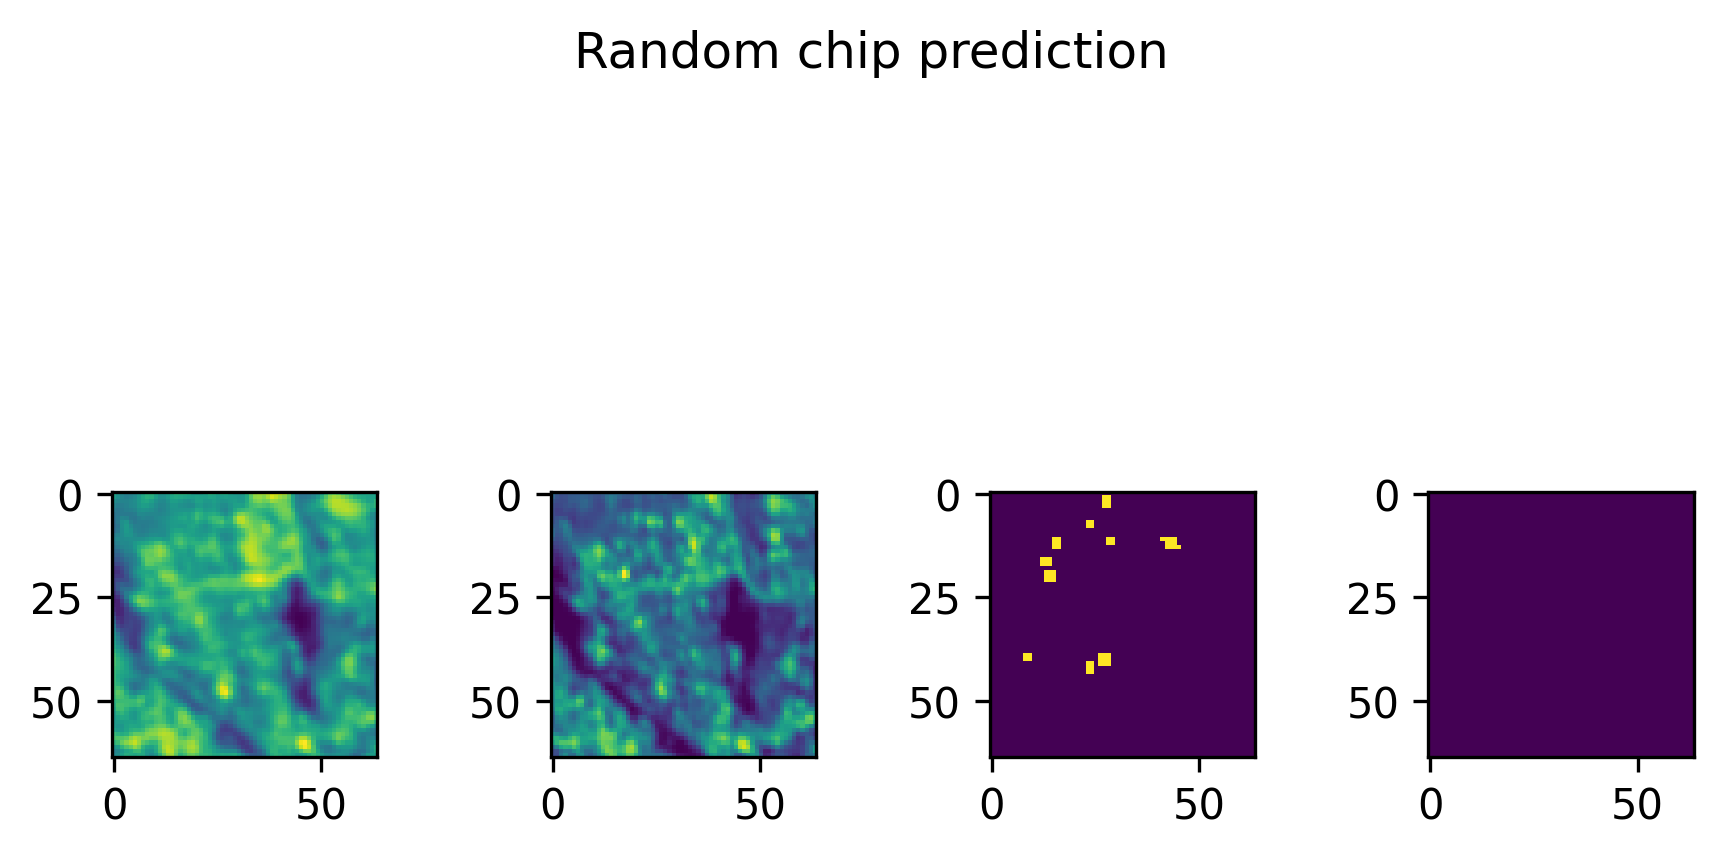

In [ ]:
batch = next(iter(dataloaders['valid']))
n = np.random.randint(BATCH_SIZE)
_, preds = torch.max(model(batch['I1'].cuda(),batch['I2'].cuda()).data,1)
fig, axs = plt.subplots(1,4)
fig.suptitle('Random chip prediction')
fig.tight_layout()
axs[0].imshow(batch['I1'][n].squeeze())
axs[1].imshow(batch['I2'][n].squeeze())
axs[2].imshow(batch['label'][n].squeeze())
axs[3].imshow(preds[n].cpu())